!ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

!ln -s ~/data/word2vec_ko.model* ~/aiffel/sentiment_classification/data

# 프로젝트

In [29]:
import pandas as pd
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.3.2


## 1) 데이터 준비와 확인

In [30]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

### 데이터로더의 기능 
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전 word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [31]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def preprocess_text(texts, stopwords, tokenizer):
    tokenized_texts = []
    for text in texts:
        tokens = tokenizer.morphs(text)
        filtered_tokens = [word for word in tokens if word not in stopwords]
        tokenized_texts.append(filtered_tokens)
    return tokenized_texts

def build_word_to_index(tokenized_texts, num_words):
    all_words = [word for tokens in tokenized_texts for word in tokens]
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(num_words-4)
    word_to_index = {word: idx+4 for idx, (word, freq) in enumerate(common_words)}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3
    return word_to_index

def texts_to_sequences(tokenized_texts, word_to_index):
    sequences = []
    for tokens in tokenized_texts:
        sequence = [word_to_index.get(word, 0) for word in tokens]
        sequences.append(sequence)
    return np.array(sequences)

def load_data(train_data, test_data, num_words=10000):
    
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any')
    
    # 한국어 토크나이저로 토큰화 & 불용어 제거
    tokenized_train_texts = preprocess_text(train_data['document'], stopwords, tokenizer)
    tokenized_test_texts = preprocess_text(test_data['document'], stopwords, tokenizer)
    
    # 사전 word_to_index 구성
    word_to_index = build_word_to_index(tokenized_train_texts, num_words)
    
    X_train = texts_to_sequences(tokenized_train_texts, word_to_index)
    X_test = texts_to_sequences(tokenized_test_texts, word_to_index)
    
    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])
    
    return X_train, y_train, X_test, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, 10000)

/tmp/ipykernel_925/4017618643.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences)


In [32]:
# Validation set 분할(10% of train set)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=42)

In [33]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [34]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

min: 0, max : 116


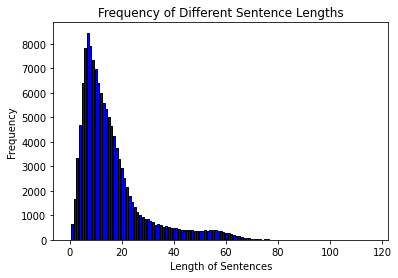

In [35]:
from collections import Counter
import matplotlib.pyplot as plt

len_of_sentences = [len(x) for x in X_train]
print(f'min: {min(len_of_sentences)}, max : {max(len_of_sentences)}')

length_counts = Counter(len_of_sentences)

x = list(length_counts.keys())
y = list(length_counts.values())

plt.bar(x, y, color='blue', edgecolor='black')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.title('Frequency of Different Sentence Lengths')
plt.show()

### 적절한 최대 문장 길이 지정

In [36]:
# 첫번째 시도로 단순히 max length 값으로 지정
maxlen = max(len_of_sentences)

### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [37]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

## 4) 모델 구성 및 validation set 구성

In [38]:
from tensorflow.keras.initializers import Constant

def model_builder1(vocab_size, word_vector_dim, maxlen):

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    return model

def model_builder2(vocab_size, word_vector_dim, maxlen, embedding_matrix):

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, 
                              embeddings_initializer=Constant(embedding_matrix),
                              input_length=maxlen,
                              trainable=True),
    tf.keras.layers.Conv1D(64, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(64, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    return model

def model_builder3(vocab_size, word_vector_dim, maxlen, embedding_matrix):

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, 
                              embeddings_initializer=Constant(embedding_matrix),
                              input_length=maxlen,
                              trainable=True),
    tf.keras.layers.Conv1D(64, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    return model


def model_lstm_builder(vocab_size, word_vector_dim, maxlen, embedding_matrix):
    
    model_lstm = tf.keras.Sequential()
    model_lstm.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, 
                                             embeddings_initializer=Constant(embedding_matrix),
                                             input_length=maxlen,
                                             trainable=True))
    model_lstm.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
    model_lstm.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
    model_lstm.add(tf.keras.layers.LSTM(128))
    model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
    model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model_lstm.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return model_lstm

## 5) 모델 훈련 개시

In [39]:
vocab_size = len(word_to_index)
word_vector_dim = 16

In [11]:
# model1, 기본형
model1 = model_builder1(vocab_size, word_vector_dim, maxlen)

history1 = model1.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.2, verbose=1)

results1 = model1.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {results1[0]}, Test Accuracy: {results1[1]}')

Epoch 1/20
206/206 [==============================] - 2s 4ms/step - loss: 0.6771 - accuracy: 0.6647 - val_loss: 0.6331 - val_accuracy: 0.7519
Epoch 2/20
206/206 [==============================] - 1s 4ms/step - loss: 0.5456 - accuracy: 0.7907 - val_loss: 0.4733 - val_accuracy: 0.8102
Epoch 3/20
206/206 [==============================] - 1s 4ms/step - loss: 0.4301 - accuracy: 0.8231 - val_loss: 0.4091 - val_accuracy: 0.8289
Epoch 4/20
206/206 [==============================] - 1s 4ms/step - loss: 0.3833 - accuracy: 0.8404 - val_loss: 0.3827 - val_accuracy: 0.8358
Epoch 5/20
206/206 [==============================] - 1s 4ms/step - loss: 0.3593 - accuracy: 0.8495 - val_loss: 0.3709 - val_accuracy: 0.8419
Epoch 6/20
206/206 [==============================] - 1s 4ms/step - loss: 0.3446 - accuracy: 0.8561 - val_loss: 0.3646 - val_accuracy: 0.8446
Epoch 7/20
206/206 [==============================] - 1s 4ms/step - loss: 0.3351 - accuracy: 0.8609 - val_loss: 0.3622 - val_accuracy: 0.8444
Epoch 

## 6) Loss, Accuracy 그래프 시각화

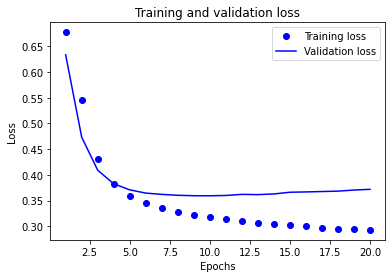

In [12]:
import matplotlib.pyplot as plt

history1_dict = history1.history

acc = history1_dict['accuracy']
val_acc = history1_dict['val_accuracy']
loss = history1_dict['loss']
val_loss = history1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

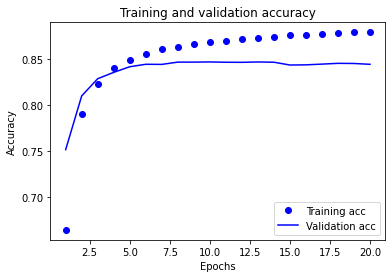

In [13]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [14]:
import os

embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [15]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.02598127, -0.0253059 , -0.01388663, -0.0056677 , -0.05123879,
        0.14731099, -0.03448881, -0.09939786,  0.03810572, -0.01338854,
       -0.00636498, -0.10653669,  0.03261983, -0.01568874, -0.05527313,
       -0.04647263], dtype=float32)

In [16]:
word_vectors.similar_by_word("사랑")

[('최선', 0.997480034828186),
 ('메이퀸', 0.9972800612449646),
 ('봐야', 0.997199535369873),
 ('최고', 0.997184693813324),
 ('눈물', 0.9970149993896484),
 ('알파치노', 0.9969419240951538),
 ('매력', 0.9969261288642883),
 ('재미있', 0.9968223571777344),
 ('필요', 0.9967065453529358),
 ('잊', 0.9964533448219299)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_ko_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_ko_file_path)
print(word2vec.wv['끝'])

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   

In [43]:
vocab_size = len(word2vec.wv)
word_vector_dim = len(word2vec.wv['영화'])
print(f'vocab_size : {vocab_size}, word_vector_dim : {word_vector_dim}')

vocab_size : 302960, word_vector_dim : 100


In [44]:
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

In [45]:
for i in range(4, len(index_to_word)):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

### 사전학습된 한국어 Word2vec 으로 학습하기

In [46]:
model2 = model_builder2(vocab_size, word_vector_dim, maxlen, embedding_matrix)

In [22]:
history2 = model2.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
4112/4112 [==============================] - 79s 19ms/step - loss: 0.4438 - accuracy: 0.7891 - val_loss: 0.3717 - val_accuracy: 0.8341
Epoch 2/20
4112/4112 [==============================] - 76s 19ms/step - loss: 0.3310 - accuracy: 0.8568 - val_loss: 0.3318 - val_accuracy: 0.8538
Epoch 3/20
4112/4112 [==============================] - 76s 19ms/step - loss: 0.2904 - accuracy: 0.8766 - val_loss: 0.3270 - val_accuracy: 0.8585
Epoch 4/20
4112/4112 [==============================] - 76s 19ms/step - loss: 0.2604 - accuracy: 0.8927 - val_loss: 0.3256 - val_accuracy: 0.8598
Epoch 5/20
4112/4112 [==============================] - 76s 19ms/step - loss: 0.2311 - accuracy: 0.9066 - val_loss: 0.3513 - val_accuracy: 0.8558
Epoch 6/20
4112/4112 [==============================] - 76s 19ms/step - loss: 0.2031 - accuracy: 0.9184 - val_loss: 0.3586 - val_accuracy: 0.8549
Epoch 7/20
4112/4112 [==============================] - 76s 19ms/step - loss: 0.1784 - accuracy: 0.9299 - val_loss: 0.3965 -

In [23]:
history2_dict = history2.history

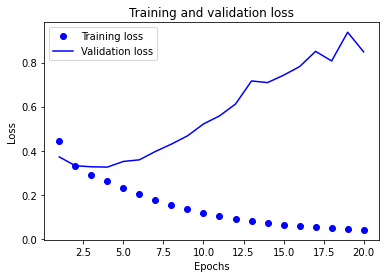

In [24]:
acc = history2_dict['accuracy']
val_acc = history2_dict['val_accuracy']
loss = history2_dict['loss']
val_loss = history2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

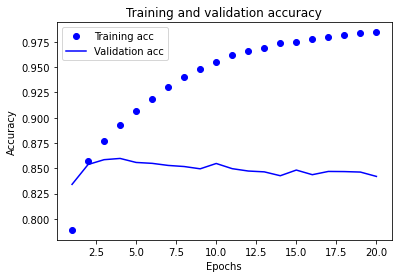

In [25]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 한국어 Word2Vec 임베딩 + LSTM Model

In [26]:
model_lstm = model_lstm_builder(vocab_size, word_vector_dim, maxlen, embedding_matrix)

In [27]:
history_lstm = model_lstm.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
4112/4112 [==============================] - 139s 32ms/step - loss: 0.3791 - accuracy: 0.8287 - val_loss: 0.3266 - val_accuracy: 0.8609
Epoch 2/20
4112/4112 [==============================] - 130s 32ms/step - loss: 0.2908 - accuracy: 0.8770 - val_loss: 0.3048 - val_accuracy: 0.8686
Epoch 3/20
4112/4112 [==============================] - 131s 32ms/step - loss: 0.2558 - accuracy: 0.8945 - val_loss: 0.3143 - val_accuracy: 0.8700
Epoch 4/20
4112/4112 [==============================] - 131s 32ms/step - loss: 0.2244 - accuracy: 0.9094 - val_loss: 0.3059 - val_accuracy: 0.8686
Epoch 5/20
4112/4112 [==============================] - 131s 32ms/step - loss: 0.1939 - accuracy: 0.9235 - val_loss: 0.3255 - val_accuracy: 0.8668
Epoch 6/20
4112/4112 [==============================] - 130s 32ms/step - loss: 0.1652 - accuracy: 0.9359 - val_loss: 0.3393 - val_accuracy: 0.8672
Epoch 7/20
4112/4112 [==============================] - 130s 32ms/step - loss: 0.1386 - accuracy: 0.9477 - val_loss: 0

KeyboardInterrupt: 

In [28]:
history_lstm_dict = history_lstm.history

NameError: name 'history_lstm' is not defined

In [ ]:
acc = history_lstm_dict['accuracy']
val_acc = history_lstm_dict['val_accuracy']
loss = history_lstm_dict['loss']
val_loss = history_lstm_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Add Dropout Layers

In [47]:
model3 = model_builder3(vocab_size, word_vector_dim, maxlen, embedding_matrix)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='auto')

history3 = model3.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/10
4112/4112 [==============================] - 78s 19ms/step - loss: 0.5539 - accuracy: 0.7095 - val_loss: 0.4305 - val_accuracy: 0.8065
Epoch 2/10
4112/4112 [==============================] - 77s 19ms/step - loss: 0.4053 - accuracy: 0.8181 - val_loss: 0.3874 - val_accuracy: 0.8412
Epoch 3/10
4112/4112 [==============================] - 77s 19ms/step - loss: 0.3633 - accuracy: 0.8426 - val_loss: 0.3748 - val_accuracy: 0.8455
Epoch 4/10
4112/4112 [==============================] - 77s 19ms/step - loss: 0.3389 - accuracy: 0.8544 - val_loss: 0.3568 - val_accuracy: 0.8553
Epoch 5/10
4112/4112 [==============================] - 77s 19ms/step - loss: 0.3216 - accuracy: 0.8638 - val_loss: 0.3530 - val_accuracy: 0.8597
Epoch 6/10
4112/4112 [==============================] - 77s 19ms/step - loss: 0.3101 - accuracy: 0.8704 - val_loss: 0.3556 - val_accuracy: 0.8618
Epoch 7/10
4112/4112 [==============================] - 77s 19ms/step - loss: 0.2989 - accuracy: 0.8756 - val_loss: 0.3331 -

In [49]:
history3_dict = history3.history

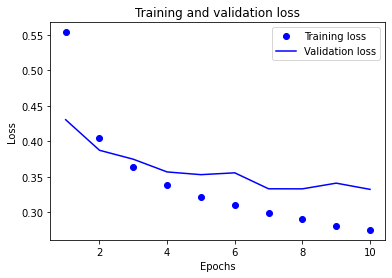

In [50]:
acc = history3_dict['accuracy']
val_acc = history3_dict['val_accuracy']
loss = history3_dict['loss']
val_loss = history3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

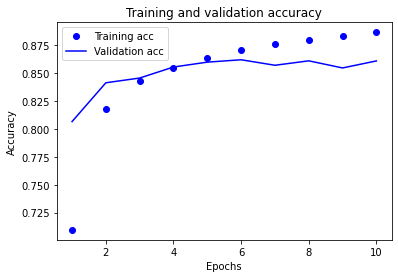

In [51]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고

* 배운 점
  - 자연어의 전처리 과정에 대해서 공부하였다. 특히 Embedding 과정을 하나하나 실행하면서 필요한것들을 배웠다.
* 아쉬운 점
  - 생각보다 학습에 시간이 오래걸려서 많은 실험을 진행하지 못했다. 추가적으로 다양한 모델과 하이퍼파라미터에 대해 실험하여 성능을 향상시켜봐야겠다.
* 느낀 점
  - NLP가 CV에 비해 막연한 감이 있었는데 직접 전체 프로세스를 겪어보니 막연히 어렵다 생각했던 부분들이 많이 해소되었다.
* 어려웠던 점
  - 임베딩 과정을 구현하면서 자잘한 에러들이 많아 시간이 오래걸렸다. 과정 별로 shape이 어떻게 변하는 지 확실히 알고 있어야겠다.